# Recurrent Neural Networks (RNNs) for Time Series Prediction

Author: John Nicholson, PhD

## Introduction

In this study we focus on using Recurrent Neural Networks or RNNs for time series prediction.  We endeavor to go beyond the basics and aim to achieve *robust* time series prediction.  Here, we consider the problem of forecasting monthly airline passengers 12-months into the future, but our goal is general-purpose time series prediction.  Towards this goal, we look at RNNs.  RNNs' architectures, as Olah (2015) notes, are naturally well suited for time series data.  Unlike traditional Artificial Neural Networks or ANNs, which learn from scalar inputs, RNNs learn from *sequences* of scalar inputs.  As Géron (2017) notes, a *recurrent neuron* learns sequences by looping its output back to itself at the next *time step* or *frame*.  This output and the input at the next time step are received by the recurrent neuron and contribute to its activation.  Such recurrent learning is what gives RNNs their so-called memory and of course their name.

## Data

Our data is Box, Jenkins, and Reinsel's (1976) *AirPassengers* data set, which can be downloaded [here](https://vincentarelbundock.github.io/Rdatasets/datasets.html).  Data consists of two comma separated columns, *Month* and *#Passengers*.  *Month* is the month of the year given in *YYYY-MM* format and *#Passengers* is the number of passengers, in thousands, that traveled in a particular month.  Data ranges from January 1949 to December 1960.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Import data, format dates, sort data ascending by date
data = pd.read_csv(
    'data/AirPassengers.csv',
    sep=',',
    header=0,
    names=['date','no_passengers'],
    usecols=['date','no_passengers'])
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['date'], ascending=True)

# Store date and no_passengers columns in numpy style arrays
dates = data['date'].as_matrix()
nos_passengers = data['no_passengers'].as_matrix()

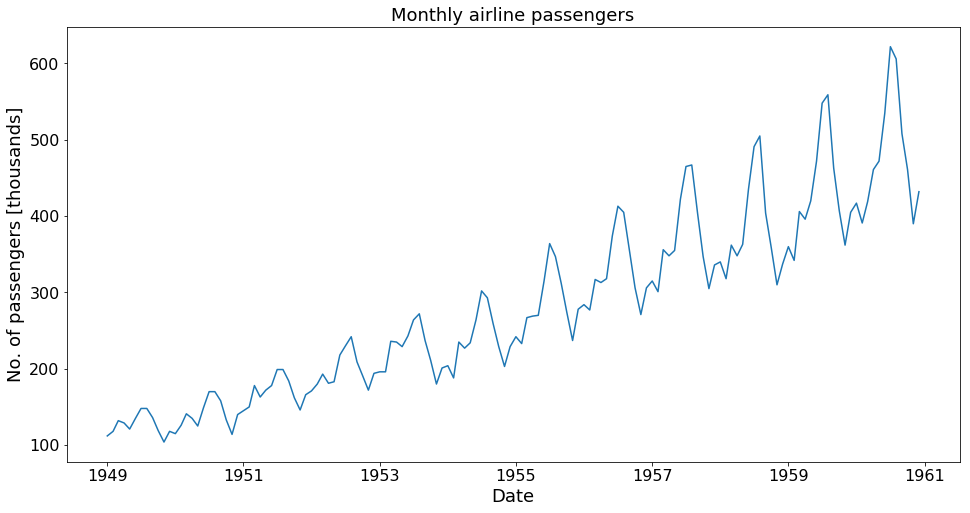

In [3]:
# Plot monthly airline passengers
plt.figure(figsize=(16,8))
plt.plot(dates, nos_passengers)
plt.title('Monthly airline passengers', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('No. of passengers [thousands]', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## Split data into training and validation sets

We wish to forecast monthly airline passengers 12-months into the future.  So we separate out our last 12-months of data from our first 132-months of data so they can be used to validate our RNN, which will be trained on the first 132-months of data only. 

In [4]:
# Number of steps (months) into the future to predict
n_pred_steps = 12

# Split data into training and validation sets
dates_train = dates[0:len(dates)-n_pred_steps]
nos_passengers_train = nos_passengers[0:len(nos_passengers)-n_pred_steps]

dates_valid = dates[len(dates)-n_pred_steps:len(dates)]
nos_passengers_valid = nos_passengers[len(nos_passengers)-n_pred_steps:len(nos_passengers)]

## Redefining the problem

Since our data has a general upward trend, new sequences of inputs used to generate predictions may, at times, be out-of-range of old sequences of inputs used to train the network.  This out-of-range issue is tantamount to extrapolation, which is bad, and affects any time series at or near its all time high or all time low.

To remedy this issue, we redefine the problem.  Instead of forecasting monthly airline passengers, we predict the percent change in monthly airline passengers from the previous month.  Note: we assume no percent change in monthly airline passengers from the previous month at the first month.

In [5]:
# Compute percent change from previous month to current month
previous_train = nos_passengers_train[0:len(nos_passengers_train)-1]
current_train = nos_passengers_train[1:len(nos_passengers_train)]
changes_train = ((current_train - previous_train) / previous_train) * 100

# Assume no percent change from previous month at first month
changes_train = np.insert(changes_train, 0, 0)

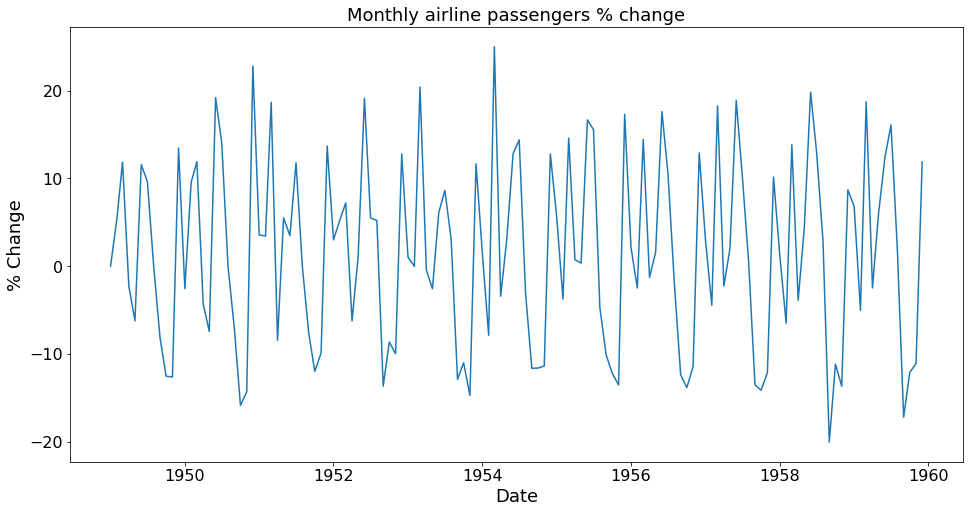

In [6]:
# Plot monthly airline passengers % change
plt.figure(figsize=(16,8))
plt.plot(dates_train, changes_train)
plt.title('Monthly airline passengers % change', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('% Change', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## Scaling

Machine learning algorithms perform best when data is scaled appropriately.  Typically, scaling of inputs, or *feature scaling*, is done using normalization or standardization.  Normalization or min-max scaling usually involves scaling inputs to the range 0 to 1.  Standardization involves subtracting out the mean and dividing by the standard deviation so that inputs have zero mean and unit standard deviation.  In general, normalization is best when inputs *do not* contain outliers and standardization is best when inputs *do* contain outliers.  However, for some machine learning algorithms, it may be preferable to use one technique or the other.   

From the "Monthly airline passengers % change" plot above, it is apparent that our input does *not* contain outliers.  Therefore, we use normalization.

In [7]:
# Normalize percent changes
changes_train_min = min(changes_train)
changes_train_max = max(changes_train)
changes_train_normalized = (changes_train - changes_train_min) / (changes_train_max - changes_train_min)

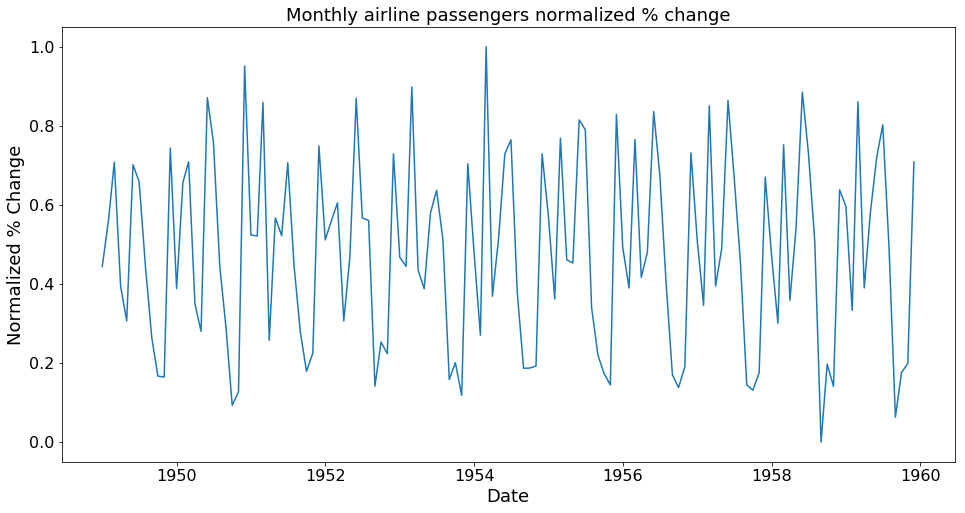

In [8]:
# Plot monthly airline passengers normalized % change
plt.figure(figsize=(16,8))
plt.plot(dates_train, changes_train_normalized)
plt.title('Monthly airline passengers normalized % change', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Normalized % Change', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## Parameters

Initialize hyperparameters.

In [9]:
# Initialize graph parameters
n_inputs = 1             # no. of nodes in input layer
n_hidden = 100           # no. of nodes in hidden layer
n_outputs = 1            # no. of nodes in output layer

# Initialize batch parameters
batch_size = 50          # no. of training examples to consider at each training iteration
n_steps = 12             # no. of steps in each input sequence

# Initialize optimizer parameters
n_iterations = 10000     # no. of training iterations to perform
learning_rate = 0.001    # learning rate for training

## Basic RNN

### Construction phase

Build computation graph.

In [10]:
# Reset the default graph
tf.reset_default_graph()

# Define placeholder nodes for batches of training inputs and outputs, respectively, to occupy
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

# Define RNN cells and a dynamic RNN, which performs fully dynamic unrolling of inputs
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_hidden, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# Stack all the outputs by reshaping from [batch_size, n_steps, n_hidden] to [batch_size * n_steps, n_hidden]
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_hidden])

# Project output by applying a single fully connected layer  
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)

# Unstack projection by reshaping from [batch_size * n_steps, n_outputs] to [batch_size, n_steps, n_outputs]
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

# Define MSE loss function, an Adam optimizer, and the training operation.
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Create node in graph that will initialize all variables when run
init = tf.global_variables_initializer()

# Create a Saver node for saving and restoring model.
saver = tf.train.Saver()

In [11]:
def next_batch(input_sequence, batch_size, n_steps):
    i_first = 0
    i_last = len(input_sequence)
    i_starts = np.random.randint(i_first, high=i_last-n_steps, size=(batch_size, 1))
    i_sequences = i_starts + np.arange(0, n_steps + 1)
    flat_i_sequences = np.ravel(i_sequences[:,:])
    flat_sequences = input_sequence[flat_i_sequences]
    sequences = flat_sequences.reshape(batch_size,-1)
    return sequences[:, :-1].reshape(-1, n_steps, 1), sequences[:, 1:].reshape(-1, n_steps, 1)

### Execution phase

Train RNN.

In [12]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(changes_train_normalized, batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 1000 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            
    saver.save(sess, "./AirPassengersModel")

0 	MSE: 0.335494
1000 	MSE: 0.0139177
2000 	MSE: 0.0117318
3000 	MSE: 0.00861321
4000 	MSE: 0.00982438
5000 	MSE: 0.00805407
6000 	MSE: 0.00804817
7000 	MSE: 0.00883125
8000 	MSE: 0.00727863
9000 	MSE: 0.0068532


In [13]:
changes_train_normalized_working = changes_train_normalized
changes_pred_normalized = np.array([])

with tf.Session() as sess:
    saver.restore(sess, "./AirPassengersModel")
    for pred in range(n_pred_steps):
        flat_X_new = changes_train_normalized_working[len(changes_train_normalized_working)-n_steps:len(changes_train_normalized_working)]
        X_new = flat_X_new.reshape(1,-1).reshape(-1, n_steps, 1) 
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        changes_pred_normalized = np.append(changes_pred_normalized, [y_pred[0, n_steps-1, 0]], axis=0)
        changes_train_normalized_working = np.append(changes_train_normalized, changes_pred_normalized, axis=0)

INFO:tensorflow:Restoring parameters from ./AirPassengersModel


In [14]:
changes_pred = changes_pred_normalized * (changes_train_max - changes_train_min) + changes_train_min

In [15]:
nos_passengers_pred = np.array([nos_passengers_train[len(nos_passengers_train)-1]])
for pred in range(n_pred_steps):
    nos_passengers_pred = np.append(nos_passengers_pred, [nos_passengers_pred[pred] + nos_passengers_pred[pred] * (changes_pred[pred] / 100)], axis=0)
nos_passengers_pred = np.delete(nos_passengers_pred, 0)

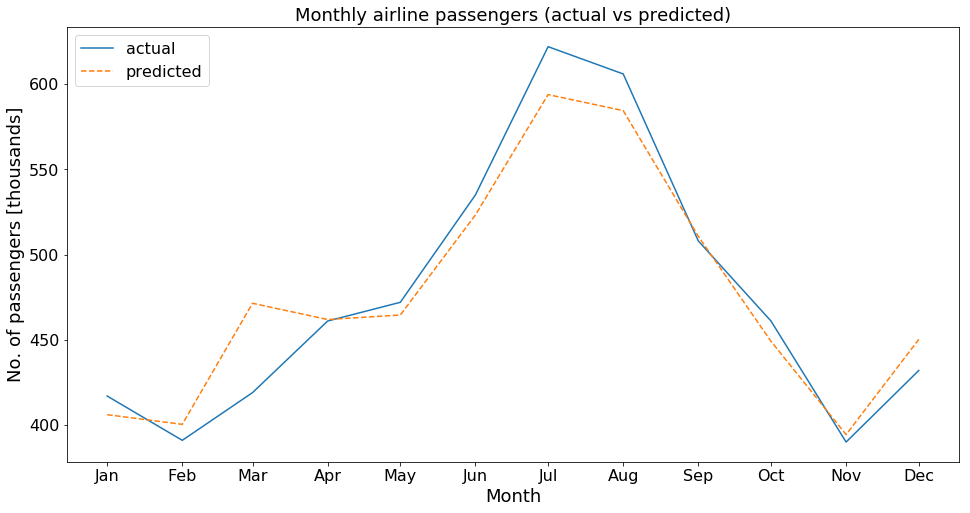

In [17]:
# Plot monthly airline passengers (validation vs prediction)
plt.figure(figsize=(16,8))
plt.plot(dates_valid, nos_passengers_valid, '-', label="actual")
plt.plot(dates_valid, nos_passengers_pred, '--', label="predicted")
plt.title('Monthly airline passengers (actual vs predicted)', fontsize=18)
plt.xlabel('Month', fontsize=18)
plt.ylabel('No. of passengers [thousands]', fontsize=18)
plt.xticks(dates_valid, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation='horizontal', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.show()

In [20]:
percent_error = np.absolute((nos_passengers_pred - nos_passengers_valid) / nos_passengers_valid) * 100
np.round(100-np.mean(percent_error))

97.0

## References

Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976). *Time Series Analysis, Forecasting and Control (3rd ed.)*. San Francisco, CA: Holden-Day.

Géron, A. (2017). *Hands-On Machine Learning with Scikit-Learn & TensorFlow*. Sebastopol, CA: O'Reilly Media, Inc.

Olah, C. (2015). Understanding LSTM Networks. *Colah's Blog*. http://colah.github.io/posts/2015-08-Understanding-LSTMs/.